## Formatting the data
The data available is not perfect. Some articles are too short to work with or contain no body. Such texts will be filtered out - The data will be loaded from a JSON and converted to a Pandas dataframe. 

Author: lkt259@alumni.ku.dk

In [165]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn')

In [166]:
#Load data - and show 120 characters of the body.
data = pd.read_json(r'data/data.json')
pd.set_option('display.max_colwidth', 220)
data.head(3)

,Id,Domain,Body,Header,PublicationDate,Uri,Byline,TextHash
0,842325,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . FOR ABONNENTER »Der var ov...,Utilfreds passager: »Prøv selv en tur klokken 7.30 en hverdagsmorgen« - politiken.dk,2002-09-17T00:00:00,https://politiken.dk/forbrugogliv/art6088327/Utilfreds-passager-%C2%BBPr%C3%B8v-selv-en-tur-klokken-7.30-en-hverdagsmorgen%C2%AB,Annemette Grundtvig,-346867430
1,842324,politiken.dk,"Klimamonitor Byrummonitor Skolemonitor Sundhedsmonitor Kulturmonitor Følg os Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« For to år siden fik forfatter ...","Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« - politiken.dk",2013-01-18T00:00:00,https://politiken.dk/forbrugogliv/art6287464/%C2%BBOfte-st%C3%A5r-jeg-og-mangler-en-ting-og-bliver-irriteret-p%C3%A5-mig-selv-over-at-jeg-har-smidt-den-ud%C2%AB,Annemette Grundtvig,-1346564151
2,842323,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . Køb abonnement Den familie...,Digitalt forældreskab: Hvilken type er du som Facebook-forælder? - politiken.dk,2006-05-17T00:00:00,https://politiken.dk/forbrugogliv/art5934818/Hvilken-type-er-du-som-Facebook-for%C3%A6lder,Annemette Grundtvig,1473032676


### Removing duplicates
We don't want duplicate articles. First, we'll remove entries with the same URI and body. I save the entries, which have empty bodies and unique URI's - Perhaps we can get the body online, if needed.

In [167]:
def same_uri(uri):
    return data[data['Uri']==uri]

print("With duplicates:", data.shape)
data = data.drop_duplicates(subset=["Body", "Uri"]) #Remove entries with same body and URI
empty_bodies = data[data['Body'] == '']    #Save empty bodied entries in another dataframe.
data = data[data['Body'] != '']
empty_bodies = empty_bodies[~empty_bodies['Uri'].isin(data['Uri'])] #Remove empty bodies, which are present in data.

print("Without duplicates:", data.shape)

With duplicates: (10000, 8)
Without duplicates: (9310, 8)


### Find the minimum length of bodies
Let's see the distribution of the body lengths.

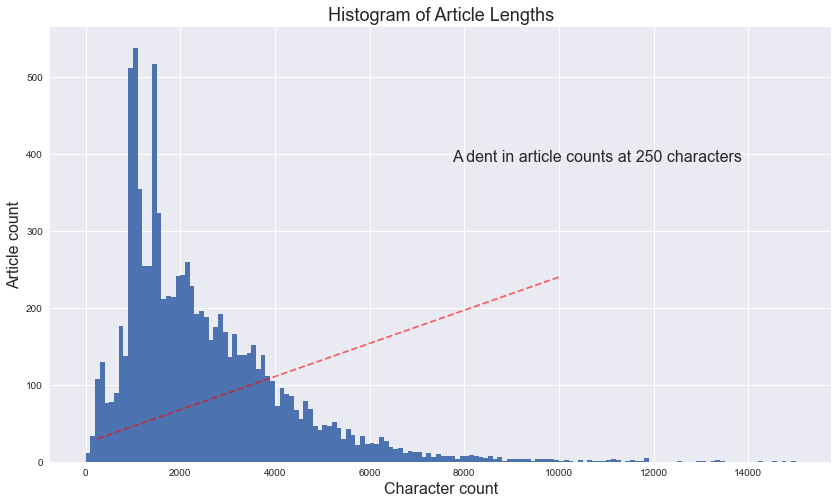

In [168]:
body_lengths = data['Body'].str.len()

desc = "A dent in article counts at 250 characters"

y, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges))
plt.title("Histogram of Article Lengths", fontsize=18)
plt.xlabel("Character count", fontsize=16)
plt.ylabel("Article count", fontsize=16)
plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
plt.plot([250,10000], [30,240], '--', c='red', alpha=.6)
#Ændr, så det passer med den endelige data.

Could that be a good separator?

### Filter the data

In [177]:
#Find end god minimumslængde - Der er mismatch mellem indices. Er det overhovedet nødvendigt at fjerne korte artikler nu?
# min_length = 90
# short_bodies = body_lengths[body_lengths < min_length]
# bad_bodies = data.iloc[short_bodies.index]
# bad_bodies.head()

It seems... Wait, do we even have to remove short articles now?

### Author insight
Remove entries, where the author only occurs once. Perhaps make sure there are not too many entries by the same author - This will not be done immediately, as we do not want to discard valuable data. 

In [178]:
#df[df.duplicated(subset=['A','B'], keep=False)]
data = data[data.duplicated(subset=['Byline'], keep=False)]
print("Unique authors: ", len(data['Byline'].value_counts()))
print(data['Byline'].value_counts()[:5],"\n...")

Unique authors:  27
Kasper Villum Jensen    1596
Karsten Østergaard      1472
Emma Busk               1050
Thomas Flensburg         919
Annemette Grundtvig      481
Name: Byline, dtype: int64 
...


### Investigating the empty bodies
The links still work on some of them, so let's look at them. Probably takes too long time... 

In [221]:
## Dette tager for lang tid. 

df = pd.DataFrame(columns=['Id', 'Domain', 'Body', 'Header', 'PublicationDate', 'Uri', 'Byline', 'TextHash'])

bod = '''Jeg kommer og gruppevoldtager dig – foran dine tre døtre. Religion og køn trigger. Der findes ingen statistik over, hvor mange forskere der rammes af trusler, men Institut for Menneskerettigheder har gennemført en undersøgelse af hadefulde ytringer på Facebook, hvor man analyserede 3.000 statistisk tilfældigt indsamlede kommentarer fra DR Nyheders og TV2 Nyheders Facebook-sider. 15 % af kommentarerne viste sig at være hadefulde. 40 % af de hadefulde kommentarer forekom i forbindelse med opslag om religion og tro, 34 % i forbindelse med flygtninge og 29 % ved nyhedsopslag om ligestilling. “Der er nogle emner, der særligt trigger en hadefuld retorik, og det er klart, at forskere, der udtaler sig i forbindelse med emner af den type, vil blive hårdt ramt. Det handler meget om værdi- og identitetspolitik og om køn og ligestilling. Der er ikke plads til nuancer og til en reel samtale på de sociale medier”, siger Lumi Zuleta, der er specialkonsulent ved Institut for Menneskerettigheder. Hun tilføjer, at undersøgelser viser, at tonen og debatformen i stor stil får de 18-29-årige og kvinderne til at afholde sig fra at deltage. “Jeg forstår godt, hvis der er forskere, som siger, at de ikke vil bruge deres tid og energi på at formidle deres forskning, fordi det er meget opslidende at skulle håndtere personangreb”, siger Lumi Zuleta. De bliver sgu pløkket ned de fucking muslimer hvis de bare så meget som nærmer sig Stigende polarisering. Vincent F. Hendricks, professor i formel filosofi ved Københavns Universitet og grundlægger og leder af Center for Information og Boblestudier, fortæller, at det sker, at han selv modtager trusler. For nylig henvendte en fra Stram Kurs sig til ham flere gange og skrev bl.a.: “Vi ved, hvor du bor”, men han har også prøvet det, der var langt værre. “Jeg fik for år tilbage tilsendt en patron med posten med en besked, hvori der stod, at “en død neger er en god neger”, fortæller Vincent Hendricks. Han tilføjer, at forskningen ved Center for Information og Boblestudier bl.a. viser, at et hurtigere informationsflow i samfundet er med til at puste til ilden, og at folk i stigende grad allierer sig med dem, de selv er enige med. Konsekvensen er, hvad forskerne kalder affektiv polarisering, altså at individer udviser stærkt negative følelser over for politiske modstandere og ikke er villige til at interagere med dem. “Der er forskningsområder, som er letantændelige, fordi de har at gøre med identitetspolitik, eller fordi forskningen handler om noget tæt på folks hverdag som fx nedlukningen af samfundet. De emner er sprængfarlige”, siger Vincent Hendricks.'''
df.loc[len(df.index)] = [932327, 'www.forskerforum.dk', bod, 'Trusler får forskere til at tie', '2021-03-11T00:00:00', 'https://www.forskerforum.dk/magasinet/2021/341/trusler-faar-forskere-til-at-tie', 'Claus Baggersgaard', hash(bod)]

bod = '''Der er få øjeblikke i Kunstnerkollektivet Vontrapps performanceforestilling ’Syndfloden’, hvor vi faktisk stiller os selv vigtige spørgsmål. Resten af tiden er forestillingen meningsløst teater, der skræmmer nysgerrige publikummere væk fra performancegenren. Denne anmelder forlader tørdokken på M/S Museet for Søfart i Helsingør med et venligt smil og et høfligt nik til en billetkontrollør. Det skal maskere en buldrende vrede over forestillingen ’Syndfloden’ af Kunstnerkollektivet Vontrapp, som spiller på Passage Festival. For sjældent er en time blevet brugt på noget så intetsigende. Det havde været væsentligt mere åndsrigt blot at sætte sig på havnekanten og stirre ud i horisonten som en anden Ole på en knold. I stedet ender vi med at stå med blå sikkerhedshjelm og gule gummihandsker på, holdende en appelsin i den ene hånd og en dåsesodavand i den anden hånd, mens vi udfører moster-aerobic i pæne kolonner. ’Syndfloden’ er performance på den gammeldags facon. Men selv da performance-genren var ny, og man blev udsat for mystiske happenings både hid og did, så var der dog en mening med galskaben. Her virker det, som om Kunstnerkollektivet Vontrapp har fået en (velsagtens god) idé, sendt fondsansøgningerne afsted, fået tilsagn om støttemidler, og siden da glemt at udvikle idéen til en egentlig forestilling. Og pludselig en dag stod publikum og ventede, og så måtte man jo vise, hvad man havde at vise. Tingene trækkes i langdrag. De første 20-30 minutter går med, at vi står oppe på grundniveau og kigger ned i museets gård, hvor performerne bevæger sig rundt og lægger rekvisitter ud på jorden. I begyndelsen, hvor en enkelt mand langsomt trækker et kabel ud, virker det industrielt og udtryksfuldt. Ikke mindst med Sandra Boss’ udmærkede lyddesign af elektronisk ambientmusik. Men da der efterhånden bliver placeret både en trappestige, spande med appelsiner, små og store træskafter, metallægter og uendeligt meget tovværk, begynder tørdokken at ligne en forladt gøglerskole. Og nu er det vores tur til at bevæge os. Vi følger den sure tropsfører, kaldet Verdenslederen, i rødt, futuristisk hunnerkriger-lignende tøj hen til trappen og ned i tørdokken. Herfra er resten af forestillingen mest et koordineringsarbejde for performerne. Med mimik og gestik signalerer de, hvor vi skal stå, og hvad vi skal gøre. Det er Verdenslederens soldater i Kansas-blå kostumer, der guider os. De er også stramme i betrækket, men de smiler og nikker venligt, som en flykabinemedarbejder, når de kan se, at vi ikke er sikre på, om vi gør det rigtigt. Til sidst får vi i fællesskab rejst noget, der med lidt fantasi godt kunne ligne et skib. Måske især for de gratister, der står oppe ved gelænderet og kunne se hele konstruktionen oppefra, hvis de altså ikke for længst var gået af ren og skær kedsomhed. Vi kæmper med autoritetstroen. Her slutter forestillingen. Netop som det så ud, som om vi endelig var klar til at gå i gang. Titlen ’Syndfloden’ henviser naturligvis til dén passage i Bibelen, hvor Vorherre beslutter sig for at begynde på en frisk ved at udrydde alt andet, end det gode og retfærdige. Syndfloden kan altså betragtes som både en begyndelse og en slutning. Om det også var tanken hos Vontrapp, er ikke til at sige. I hvert fald bliver slutningen en begyndelse. Og da vi endelig forstår, at forestillingen er slut (fordi de medvirkende er gået), og vi efterhånden overvinder respekten for autoriteten i rødt, begynder vi at lægge rekvisitterne fra os og drysse afsted fra skuepladsen igen. Forestillingens bedste side er, at den får os til at stille spørgsmål til os selv. Ville vi adlyde en leder under en krisesituation? Ville vi kunne arbejde sammen? Bygger vi arken, fordi vi er nødt til det, eller fordi nogle siger, at vi er nødt til det? Det er ikke uden relevans i en coronatid, men det er absolut ikke den bedste måde at stille den slags spørgsmål på. For det fungerer kun i de par minutter, hvor vi står og kigger forvirret på hinanden; hvor nogle klapper og begynder at tale sammen, mens andre stadig står og udfører den opgave, de er blevet sat til. Resten af tiden er forestillingen lige dele byggerod, rytmisk gymnastik og tankeløst teater. Performancegenren kan noget, som andre scenekunstformer ikke kan. Men den bliver ofte skudt i skoene at være for arty-farty og ekskluderende. Det skyldes forestillinger som ’Syndfloden’. Hvis nye performancepublikummer begynder her, kan denne anmelder ikke bebrejde dem, at de aldrig kommer tilbage igen.'''
df.loc[len(df.index)] = [932328, 'http://www.teateravisen.dk', bod, 'Moster-aerobic og en surmulende verdensleder', '2020-01-08T00:00:00', 'http://www.teateravisen.dk/moster-aerobic-og-en-surmulende-verdensleder.html', 'Morten Hede', hash(bod)]

df

,Id,Domain,Body,Header,PublicationDate,Uri,Byline,TextHash
0,932327,www.forskerforum.dk,"Jeg kommer og gruppevoldtager dig – foran dine tre døtre. Religion og køn trigger. Der findes ingen statistik over, hvor mange forskere der rammes af trusler, men Institut for Menneskerettigheder har gennemført en un...",Trusler får forskere til at tie,2021-03-11T00:00:00,https://www.forskerforum.dk/magasinet/2021/341/trusler-faar-forskere-til-at-tie,Claus Baggersgaard,4039032661491534906
1,932328,http://www.teateravisen.dk,"Der er få øjeblikke i Kunstnerkollektivet Vontrapps performanceforestilling ’Syndfloden’, hvor vi faktisk stiller os selv vigtige spørgsmål. Resten af tiden er forestillingen meningsløst teater, der skræmmer nysgerri...",Moster-aerobic og en surmulende verdensleder,2020-01-08T00:00:00,http://www.teateravisen.dk/moster-aerobic-og-en-surmulende-verdensleder.html,Morten Hede,-6486673911442387243


In [192]:
data.keys()

Index(['Id', 'Domain', 'Body', 'Header', 'PublicationDate', 'Uri', 'Byline',
       'TextHash'],
      dtype='object')

In [215]:
empty_bodies['Uri'][20:30]

8966         http://www.teateravisen.dk/moster-aerobic-og-en-surmulende-verdensleder.html
8968           http://www.teateravisen.dk/paa-vej-mod-stjernerne-i-tantes-luftballon.html
8975           http://www.teateravisen.dk/en-god-historie-om-den-nye-dreng-i-klassen.html
8976       http://www.teateravisen.dk/flygtningekrisen-sat-i-scene-for-boern-og-unge.html
8977      http://www.teateravisen.dk/i-skoven-blaeser-de-klassiske-eventyr-et-stykke.html
8978                  http://www.teateravisen.dk/maerkvaerk-udfordrer-tabu-om-doeden.html
8982    http://www.teateravisen.dk/et-underbelyst-identitetskriseproblem-blandt-unge.html
8986         http://www.teateravisen.dk/terapeutisk-vandring-igennem-afskedens-faser.html
8991                                  http://www.teateravisen.dk/det-siger-blip-baat.html
8993                               http://www.teateravisen.dk/naar-fuglen-er-floejet.html
Name: Uri, dtype: object

In [208]:
data['Body'][0], data['TextHash'][0]

('Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . FOR ABONNENTER »Der var overhovedet ingen beskeder over højttaleren« »Det har været ganske forfærdeligt. Er blevet meget forsinket på arbejde og hjem. Overfyldte toge, aflyste toge, små toge (ikke lange), toge der pludselig ikke holdt på visse stationer, så man blev over 30 min. forsinket. Det ville klæde DSB at give penge retur, når man har periodekort og i den grad ikke får den vare, man har betalt for. Ofte er der overhovedet ingen beskeder over højttaleren, og på skiltningen på perronen går afgangstiden ned fra 10 min. til 0 og derpå forfra uden tog og uden forklaring. Prøv selv en tur kl. 7.30 en hverdagsmorgen!!!!!«. Der skete en fejl, prøv igen senere Der skete en fejl, prøv igen senere eller søg hjælp via vores kundecenter luk Prøv Politiken i 30 dage for kun 1 kr. Få adgang til Politikens

In [206]:
hash(bod)

4039032661491534906